# Analysis Template
WIP Analysis template, adapted from Margaux's notebook from 07/12/2023.

In [1]:
#enables autoreloding of modules
%load_ext autoreload
%autoreload 2

import os
from copy import deepcopy

import skimage
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

from htbam.image.processing import chip
from htbam.image.processing import experiment as exp
from htbam.image.processing import chipcollections as collections

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline

from pathlib import Path 

#Configuration settings for pandas and seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style='ticks', context='paper', font_scale=1.2, rc={"lines.linewidth": 1.2})

#enable inline plotting of matplotlib figures
%matplotlib inline

#set the figure format to SVG
%config InlineBackend.figure_format = 'svg'


## 1. Establish experiment and pinlist

In [ ]:
### Input Data:
# pinlist CSV
# stitched images
# chamber radius
# device corners (make automatic?)

In [2]:
###Experiment Description:
description = 'ADK_ortholog_MM_v2'
operator = 'MMP'
device_name = 'd2'
#Standard Curve: (add these as variables)
# ['std_slope_units'] = 'RFU/uM'
# ['substrate_name'] = 'ADP'
# ['experimental_day'] = '20230628'
# ['setup'] = '1'
# ['device'] = 'd2'
# ['assay_type'] = 'NADPH'
# ['position'] = [(int(r['y']),int(r['x'])) for i,r in fitted_standards_filtered.iterrows()]
#Experiment: (add these as variables)
# ['std_slope_units'] = 'RFU/uM'
# ['substrate_name'] = 'ADP'
# ['experimental_day'] = '20230628'
# ['setup'] = '1'
# ['device'] = 'd2'
# ['assay_type'] = 'NADPH'
# ['position'] = [(int(r['y']),int(r['x'])) for i,r in fitted_standards_filtered.iterrows()]


###input files:
root = '/mnt/c/Users/Nicholas/workspace/pinney_lab_data/on_chip_example/20230712'
pinlist_file = '20230712_adk_print_pinlist.csv'
experiment_stitched_image = root+'/button_quant/20230712-130155-d2_button_quant_egfp_5_egfp_2x2_sensitivity_4x/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif' #tif
standard_curve_stitched_image_dir = root+'/standard_curve/Analysis/5/StitchedImages' #directory of tifs
chamber_ref_image = root+'/standard_curve/Analysis/5/StitchedImages/BGSubtracted_StitchedImg_1000_5_500.tif' #To process the kinetic data, we need to define the locations of each chamber in the images. We typically use an image where chamber outlines are very obvious, such as the image of our highest concentration in our standard curve

###output files:
output_summary_csv_experiment = '/20230712_adk_orthologs_egfp_summary.csv'
output_summary_image_experiment = ''
output_summary_image_standard_curve = ''

###experiment imaging variables:
exposure_time_experiment = 5 #ms
imaging_channel_experiment = 2 #(don't know what this means)

###standard curve imaging variables:
exposure_time_standard_curve = 1000 #ms
imaging_channel_standard_curve = 5 #(don't know what this means)

###kinetics variables:
#Make these make more sense! We should be storing the actualy concentrations somewhere. We are already specifying substrate above.
kinetics_dir = Path(root+'/kinetics')
button_dir = Path(root+'/button_quant')
gfp_descriptions = ['button_quant_egfp']
kinetic_descriptions = ['7_8125uM_ADP',
                        '15_625uM_ADP',
                        '31_25uM_ADP',
                        '62_5uM_ADP',
                        '125uM_ADP',
                        '250uM_ADP',
                        '500uM_ADP',
                        '1000uMADP',
                        '2000uM_ADP',
                        '4000uM_ADP',
                        '8000uM_ADP']
concentrations = [15.625,
                 31.125,
                 62.5,
                 125,
                 250,
                 500,
                 1000,
                 2000,
                 4000,
                 8000,
                 16000]

###Initial rate fitting:
# Will be incorporated into visualization code
#drop wells below these threshholds:
# 'initial_rate'] > 0
# 'std_r2'] > 0.98
# 'enzyme_conc_nM'] > 1.5
# 'mm_tofit_mask'] == True
# 'filter_initial_rate_r2'] > 0.8

#NF: new variables to add:
#device_width, device_height

#NF: new functions to add:
# Step 2: Get the device corners automatically
# For all steps: need to know when we're generating files, and what the filenames are. Much is hidden...

#NF: new FLAGS to be added:
#Should we process each substrate conc? Make this better, add to vis code.
mmfit_mask_mapper = {'7_8125uM_ADP': True, 
                     '15_625uM_ADP': True, 
                     '31_125uM_ADP': True, 
                     '62.5uM_ADP': True, 
                     '125uM_ADP': True, 
                     '250uM_ADP': True, 
                     '500uM_ADP': True,
                     '1000uMADP': True,
                     '2000uM_ADP': True,
                     '4000uM_ADP': True,
                     '8000uM_ADP': True}
# FLAG: Want to do image processing? Or skip to fitting and load from file?

e = exp.Experiment(description, root, operator)

INFO     Experiment Initialized | Description: ADK_ortholog_MM_v2, Operator: MMP


In [3]:
#pinlist = e.read_pinlist('/Users/margauxpinney/code/lab-notebook-pinney/20230712_ADK_ortho_v2/20230712_adk_print_pinlist.csv')
pinlist = e.read_pinlist(pinlist_file)
pinlist.head(5)

Indices    MutantID
x y                    
1 1  (1, 1)  M_caps_ADK
  2  (1, 2)  P_syri_ADK
  3  (1, 3)  L_reut_ADK
  4  (1, 4)  G_ther_ADK
  5  (1, 5)       bmADK

## 2. Add devices and corners

In [4]:
# Top left, top right, bottom left, bottom right
#Each physical chip is a device, these are the center of the reaction chambers. 

#NF: where do these come from? The pixels in the raw images?
#add vars for all these
d2_corners = ((469, 445),(6738,440),(482,6815),(6754,6808)) 
d2 = exp.Device('s1', 'd2', (32, 56), pinlist, d2_corners)


### Non-standard chamber-finding parameters

In [5]:
#for 2x2 images, 32 or 33 pixels works well

#NF: How do we choose this? Also just measuring from image?
print('Old Chamber Radius: {} pixels'.format(chip.Stamp.chamberrad))
chip.Stamp.chamberrad = 33#33 in 2x2
print('New Chamber Radius: {} pixels'.format(chip.Stamp.chamberrad))


Old Chamber Radius: 16 pixels
New Chamber Radius: 33 pixels


## 3. Execute button analyses

#### Quantify egfp fluorescence on buttons

In [6]:
#NF: replace p2 with "stitched_image" everywhere
#Replace image_channel, exposure_time with variables

# Path to the stitched image you want to quantify
p2 = stitched_image

# Prepare ChipQuant object
d2_GFPQuant = collections.ChipQuant(d2, 'ButtonReference')

# Load image into memory
d2_GFPQuant.load_file(p2, '2', 5)


##### Process

In [7]:
# Find buttons, extract intensity attributes
d2_GFPQuant.process()


# Summarize attributes as a pandas dataframe
quant_report = d2_GFPQuant.summarize()


Finding Buttons: 100%|██████████| 1792/1792 [02:26<00:00, 12.21it/s]


##### Save Summary/Image

In [8]:
# Save csv of button intensities
quant_report.to_csv(output_summary_csv_experiment)

# Save image stamped and annotated with intensities for visual inspection
d2_GFPQuant.save_summary_image()


In [97]:
#Dash app:
#Show a i by j grid of images
#overlay those images with a color based on an i by j grid of True/False values
#on hover, show the location of the image and a picture we provide

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import numpy as np
from PIL import Image, ImageEnhance

app = dash.Dash(__name__)

app.layout = html.Div([
    # Create a grid of images
    dbc.Row([
        dbc.Col(
            dbc.Card(
                dbc.CardImg(
                    src="data:image/png;base64,...", # The base64 encoded image source
                ),
                style={"width": "4rem"}
            )
        )
    ]),
    # Container to show the corresponding image and coordinates on hover
    html.Div(id='hover-image-container')
])

@app.callback(
    Output('hover-image-container', 'children'),
    [Input(f"image-{i}-{j}", "n_clicks") for i in range(x) for j in range(y)]
)
def display_hover_image(*args):
    triggered_id = dash.callback_context.triggered[0]["prop_id"].split(".")[0]
    
    if "image" in triggered_id:
        i, j = map(int, triggered_id.split("-")[1:])
        # Display the corresponding image from the new array and the x, y coordinates
        hover_image_src = "data:image/png;base64,..."
        return [
            html.Img(src=hover_image_src, style={"width": "100px"}),
            html.P(f"Coordinates: {i}, {j}")
        ]
    return []

if __name__ == '__main__':
    app.run_server(debug=True)


NameError: name 'x' is not defined

In [116]:
import dash
from dash import html
import dash_bootstrap_components as dbc

rows=5
columns=4

def encode_img():
    with open("temp.png", "rb") as image_file:
        img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
    return img_src

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
#d2_GFPQuant.chip.stamps[i][j].data

# Create a grid of images
image_urls = [
    "https://via.placeholder.com/150",
    "https://via.placeholder.com/150",
    "https://via.placeholder.com/150",
    "https://via.placeholder.com/150",
    "https://via.placeholder.com/150",
    "https://via.placeholder.com/150"
]

image_grid = [dbc.Row(
    [ dbc.Col(html.Img(src=encode_img(d2_GFPQuant.chip.stamps[i][j].data), style={"width": "100%"})) for i in range(columns)],
    style={ "margin-left": "0px", "margin-right": "0px" }
    ) for j in range(rows)]

app.layout = html.Div(
    image_grid
)

app.run_server(mode='inline')

In [88]:
#make a matplotlib figure with 32x56 subplots
#each subplot is a chip stamp
fig, ax = plt.subplots(56, 32, figsize=(56, 32))
#loop through the chip stamps and plot them
for i in range(32):
    for j in range(56):
        ax[j, i].imshow(d2_GFPQuant.chip.stamps[i][j].data)
        #remove the axes
        ax[j, i].axis('off')

#remove the space between the subplots
plt.subplots_adjust(wspace=0, hspace=0)

#set the overall dimensions of the figure to display:
fig.set_size_inches(32/3, 56/3)


#show the figure
plt.show()
#plt.imshow(d2_GFPQuant.chip.stamps[0][2].data)
#plt.show()

(100, 100)


FloatSlider(value=1.0, max=2.0, min=0.1)

1.529669874221839 0.11068418664690258 0.15030174551279565


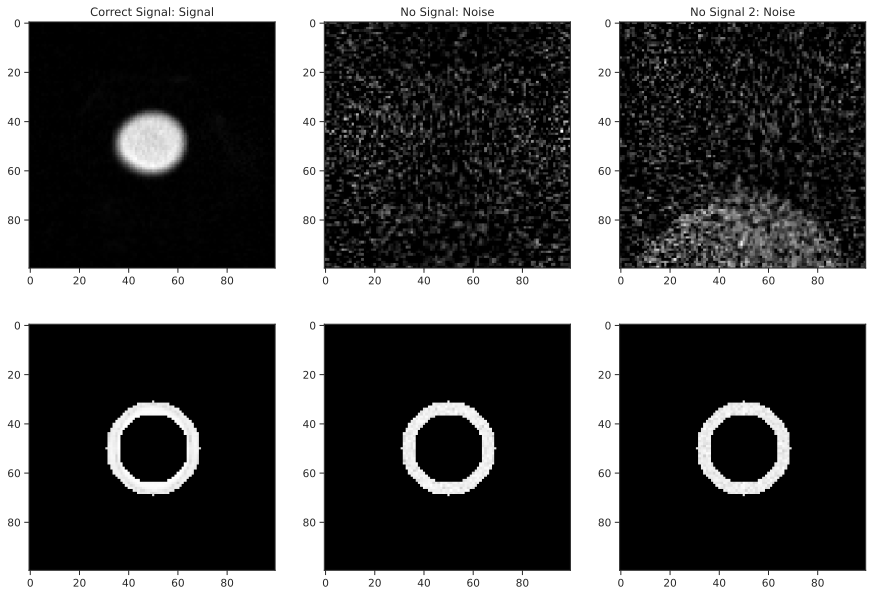

1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565
1.529669874221839 0.11068418664690258 0.15030174551279565


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Compute the 2D Fourier Transform and return the shifted power spectrum
def compute_power_spectrum(img):
    f_transform = np.fft.fft2(img)
    f_transform_centered = np.fft.fftshift(f_transform)
    power_spectrum = np.abs(f_transform_centered)
    return power_spectrum

# Create a bandpass filter with given center radius and width
def create_bandpass_filter(img_shape, center_radius, width):
    print(img_shape)
    rows, cols = img_shape
    crow, ccol = rows // 2, cols // 2
    x, y = np.ogrid[:rows, :cols]
    distance_from_center = np.sqrt((x - crow)**2 + (y - ccol)**2)
    mask = np.logical_and(distance_from_center >= (center_radius - width/2),
                          distance_from_center <= (center_radius + width/2))
    return mask

# Compute the energy ratio of inside the filter to higher frequencies beyond the filter
def compute_high_frequency_energy_ratio(filtered_ps, bandpass_filter):
    energy_inside = np.sum(filtered_ps[bandpass_filter]**2)
    distance_from_center = np.sqrt((filtered_ps.shape[0] // 2 - np.arange(filtered_ps.shape[0]))[:, np.newaxis]**2 +
                                   (filtered_ps.shape[1] // 2 - np.arange(filtered_ps.shape[1]))**2)
    high_freq_mask = distance_from_center > (33/2 + 5/2)
    energy_high_freq = np.sum(filtered_ps[high_freq_mask]**2)
    if energy_high_freq == 0:
        return np.inf
    return energy_inside / energy_high_freq

def compute_signal_ratio(img, bandpass_filter):
    power_spectrum = compute_power_spectrum(img)
    energy_ratio = compute_high_frequency_energy_ratio(power_spectrum, bandpass_filter)
    return energy_ratio

def batch_compute_signal_ratios(imgs, filter_radius, filter_width):
    bandpass_filter = create_bandpass_filter(imgs[0].shape, filter_radius, filter_width)
    ratios = []
    for img in imgs:
        ratios.append(compute_signal_ratio(img, bandpass_filter))
    return ratios

# Example usage:

# Load the images
correct_signal_img =    d2_GFPQuant.chip.stamps[2][0].data
no_signal_img =         d2_GFPQuant.chip.stamps[1][0].data
no_signal_img_2 =       d2_GFPQuant.chip.stamps[0][1].data

ratio_correct_signal, ratio_no_signal, ratio_no_signal_2 = batch_compute_signal_ratios([correct_signal_img, no_signal_img, no_signal_img_2], 33/2, 5)

# Classify images based on the high frequency energy ratio using a threshold


# Plot the images and their power spectra, and set the titles to include the classification
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

def update_plot(amplitude):
    classification_correct_signal =     "Signal" if ratio_correct_signal_high_freq > threshold_ratio_high_freq else "Noise"
    classification_no_signal =          "Signal" if ratio_no_signal_high_freq > threshold_ratio_high_freq else "Noise"
    classification_no_signal_2 =        "Signal" if ratio_no_signal_2_high_freq > threshold_ratio_high_freq else "Noise"

    ax[0, 0].set_title("Correct Signal: " + classification_correct_signal)
    ax[0, 1].set_title("No Signal: " + classification_no_signal)
    ax[0, 2].set_title("No Signal 2: " + classification_no_signal_2)

    fig.canvas.draw_idle()

def plot_classifications(threshold_ratio_high_freq):
    threshold_ratio_high_freq = 1.0
    classification_correct_signal =     "Signal" if ratio_correct_signal_high_freq > threshold_ratio_high_freq else "Noise"
    classification_no_signal =          "Signal" if ratio_no_signal_high_freq > threshold_ratio_high_freq else "Noise"
    classification_no_signal_2 =        "Signal" if ratio_no_signal_2_high_freq > threshold_ratio_high_freq else "Noise"

    print(ratio_correct_signal_high_freq, ratio_no_signal_high_freq, ratio_no_signal_2_high_freq)

    e = 0.0001
    ax[0, 0].imshow(correct_signal_img, cmap='gray')
    ax[1, 0].imshow(np.log(correct_signal_power_spectrum*bandpass_filter+e), cmap='gray')
    #ax[1, 0].imshow(np.log(correct_signal_power_spectrum), cmap='gray')

    ax[0, 1].imshow(no_signal_img, cmap='gray')
    ax[1, 1].imshow(np.log(no_signal_power_spectrum*bandpass_filter+e), cmap='gray')

    ax[0, 2].imshow(no_signal_img_2, cmap='gray')
    ax[1, 2].imshow(np.log(no_signal_power_spectrum_2*bandpass_filter+e), cmap='gray')

    ax[0, 0].set_title("Correct Signal: " + classification_correct_signal)
    ax[0, 1].set_title("No Signal: " + classification_no_signal)
    ax[0, 2].set_title("No Signal 2: " + classification_no_signal_2)

import ipywidgets as widgets
from IPython.display import display

# Create a slider widget for the amplitude variable
amplitude_slider = widgets.FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0)

# Create a callback function for the slider widget
def on_slider_change(change):
    plot_classifications(change.new)

# Attach the callback function to the slider widget
amplitude_slider.observe(on_slider_change, names='value')

# Display the slider widget
display(amplitude_slider)

# Plot the initial data with the default amplitude
plot_classifications(amplitude_slider.value)


In [ ]:
d2_GFPQuant.summarize()

## 4. Standards

In [ ]:
#NF: Add exposure time, imaging_channel, device_name variables here

# Create a standard series, load stitched images
p_d2 = standard_curve_stitched_image_dir

# Prepare ChipQuant object
d2_NADPH = collections.StandardSeries(d2, '5')

# Load images into memory
d2_NADPH.load_files(p_d2, '5', 1000)


In [ ]:
#NF: visualize here!
#rather than doing all the following processing, we can just exclude bad wells after this.

# Find chambers, extract intensity attributes
d2_NADPH.process(coerce_center = False)


In [ ]:
#NF: Add output paths here!

# Save csv of chamber intensities at different standard concentrations
d2_NADPH.save_summary()

# Save standard images stamped and annotated with intensities for visual inspection
d2_NADPH.save_summary_images()


### fit standards

In [ ]:
#NF: Is this necessary if we did image processing?

#load processed standard data
standard_data = pd.read_csv(root+'/standard_curve/Analysis/5/StitchedImages/d2_5_StandardSeries_Analysis.csv.bz2')

#add an "indicies" column that corresponds to the x & y position of the chamber on the chip
standard_data['indices'] = standard_data.x.astype('str') + ',' + standard_data.y.astype('str')

standard_data.head(2)


In [ ]:
#NF: This can be replaced with kinetics linear fit
#NF: r^2 here is PEARSON CORRELATION not R2!!!
#NF: Add variables at the top for the details in the DF, like slope units, substrate name, etc.

#takes a DataFrame df as input and performs a linear regression analysis on the data in the DataFrame
def fit_standard_linear(df):
    
    # Make a copy of the input DataFrame and sort it based on 'concentration_uM' column.
    dfcopy = df.copy().sort_values('concentration_uM')
    
    # Perform linear regression on the 'concentration_uM' and 'sum_chamber' columns of the DataFrame.
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.concentration_uM, df.sum_chamber)

    # Create a new pandas Series to store the results of the linear regression analysis.
    # Define specific index names to store each result.
    fitted_series = pd.Series(data = [df.iloc[0].id,
                      dfcopy.iloc[0].x, dfcopy.iloc[0].y, 
                      dfcopy.concentration_uM.values.tolist(), 
                      dfcopy.sum_chamber.values.tolist(),
                      dfcopy.std_chamber.values.tolist(),
                     slope, intercept, r_value**2, p_value, std_err],
              index = ['id', 'x', 'y', 'std_concs', 'std_summed_intensity', 'std_stddev_intensity', 'std_slope', 
                       'std_intercept', 'std_r2', 'std_pvalue', 'std_stderr'])
    return fitted_series


# Fit linear regression by chamber
# Group the DataFrame 'standard_data' by the values in the 'indices' (i.e. chamber coord) column and apply the 'fit_standard_linear' function to each group. 
# The result is a Series containing the output of linear regression analysis for each chamber

fitted_standards_filtered = standard_data.groupby('indices').apply(fit_standard_linear)

# Add additional descriptors
fitted_standards_filtered['std_slope_units'] = 'RFU/uM'
fitted_standards_filtered['substrate_name'] = 'ADP'
fitted_standards_filtered['experimental_day'] = '20230628'
fitted_standards_filtered['setup'] = '1'
fitted_standards_filtered['device'] = 'd2'
fitted_standards_filtered['assay_type'] = 'NADPH'
fitted_standards_filtered['position'] = [(int(r['y']),int(r['x'])) for i,r in fitted_standards_filtered.iterrows()]

fitted_standards_filtered = fitted_standards_filtered.sort_values(by = 'position')
fitted_standards_filtered.head(2)


In [ ]:
#NF: Completely replace this with new visualization code.

# Create a figure with subplots for each regression line
# This function is slow. Would be better to plot separately and click through?

def plot_all_std_curves(df, filename = 'NADPH_standard_curves_by_chamber'):
    fig, ax = plt.subplots(nrows=32, ncols=56, figsize=(200, 150))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    # Flatten the axes array for easy indexing
    ax = ax.flatten()
    
    xseq = np.linspace(0, 500, num=100)
    
    def linear(x, m, b):
        return (m*x) + b
    
    i = 0
    for index,row in df.iterrows():
        pos = '{},{}'.format(row['x'], row['y'])
        m = row['std_slope']
        b = row['std_intercept']
        rr = round(row['std_r2'],3)
        
        ax[i].plot(xseq, linear(xseq, m, b), color = 'r', label = 'r2 = {}, slope = {}'.format(rr, round(m,1)))
        ax[i].scatter(row['std_concs'], row['std_summed_intensity'], color = 'b', label = 'Data')
    
        # Set labels and title for the plot
        ax[i].set_xlabel('[NADPH]', fontsize = 8)
        ax[i].set_ylabel('Summed_RFU', fontsize = 8)
        ax[i].set_title('Chamber {}'.format(pos), fontsize = 8, fontweight='bold')
    
    
        # Add legend
        ax[i].legend(fontsize = 8)
        i = i+1
    
    # Save the plot
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig('{}.pdf'.format(filename), format='pdf')

plot_all_std_curves(fitted_standards_filtered, 'NADPH_standard_curves_by_chamber')

In [ ]:
#NF: prototype of new visualization.
#NF: This should be heavily abstracted so we can show different plots/types of data in the 56x32 "chip" format.
#NF: Eventually want to make this a function that can accept plots OR image data, and color filters over the boxes, etc. 

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objs as go
import numpy as np
import json
import base64
import time

def plot_all_std_curves_new(df, filename = 'NADPH_standard_curves_by_chamber'):
    # Make the image array
    img_array = np.zeros([56,32])
    for index,row in df.iterrows():
        pos = '{},{}'.format(row['x'], row['y'])
        m = row['std_slope']
        b = row['std_intercept']
        rr = round(row['std_r2'],3)
        img_array[int(row['y']-1),int(row['x']-1)] = rr
    
    #Create the figure
    layout = go.Layout()
    fig = go.Figure(layout=layout, data=go.Heatmap(z=img_array, colorscale='Viridis'))
    fig.update_layout(title='NADPH standard curve slopes by chamber', 
                        yaxis=dict(scaleanchor="x", scaleratio=1, autorange='reversed'), 
                        xaxis=dict(scaleratio=1),
                        plot_bgcolor='rgba(0,0,0,0)',
                        width=600, height=600,
                        hovermode='x')
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)

    #create dash app:
    app = JupyterDash(__name__)
    app.layout = html.Div([
        dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
        dcc.Tooltip(id="graph-tooltip"),
    ])

    #fig.update_traces(hoverinfo="none", hovertemplate=None)

    @app.callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph", "hoverData"),
    )
    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        # demo only shows the first point, but other points may also be available
        pt = hoverData["points"][0]
        bbox = pt["bbox"]

        plot_data = df[(df['x'] == pt['x']+1) & (df['y'] == pt['y']+1)]
        x_data = plot_data['std_concs'][0]
        y_data = plot_data['std_summed_intensity'][0]
        m = plot_data['std_slope'][0]
        b = plot_data['std_intercept'][0]

        #make a simple matplotlib plot
        fig, ax = plt.subplots()
        ax.scatter(x_data, y_data)
        if not (np.isnan(m) or np.isnan(b)):
            #return False, no_update, no_update
            ax.plot(x_data, m*np.array(x_data) + b)
        #reduce whitespace on margins of graph:
        ax.margins(0.05)
        plt.savefig('temp.png')
        plt.close()

        # #read in temp file as base64 encoded string:
        with open("temp.png", "rb") as image_file:
            img_src = "data:image/png;base64," + str(base64.b64encode(image_file.read()).decode("utf-8"))
        
        children = [
            html.Div(children=[
                html.H3('{},{}'.format(pt['x'], pt['y']), style={"color": 'black', "fontFamily":"Arial"}),
                #add the image with reduced whitespace:
                html.Img(src=img_src, style={"width": "100%"}),
            ],
            style={'width': '200px', 'white-space': 'none'})
        ]

        return True, bbox, children
    
    app.run_server(debug=True, mode='inline')


plot_all_std_curves_new(fitted_standards_filtered)

In [ ]:
#NF: completely replace

# plot how standard curve parameters vary based on location in the device

def plot_std_curve_parameters(df, filename = 'standard_curve_parameters'):
    # plot how slope and r2 vary accross the chip
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    # Flatten the axes array for easy indexing
    ax = ax.flatten()
    
    ax[0].scatter(df['x'], df['std_r2'], color = 'b')
    ax[0].set_xlabel('x-index', fontsize = 12)
    ax[0].set_ylabel('r2', fontsize = 12)
    
    ax[1].scatter(df['y'], df['std_r2'], color = 'b')
    ax[1].set_xlabel('y-index', fontsize = 12)
    ax[1].set_ylabel('r2', fontsize = 12)
    
    ax[2].hist(df['std_r2'])
    ax[2].set_xlabel('r2', fontsize = 12)
    ax[2].set_ylabel('count', fontsize = 12)
    
    ax[3].scatter(df['x'], df['std_slope'], color = 'b')
    ax[3].set_xlabel('x-index', fontsize = 12)
    ax[3].set_ylabel('slope', fontsize = 12)
    
    ax[4].scatter(df['y'], df['std_slope'], color = 'b')
    ax[4].set_xlabel('y-index', fontsize = 12)
    ax[4].set_ylabel('slope', fontsize = 12)
    
    ax[5].hist(df['std_slope'])
    ax[5].set_xlabel('slope', fontsize = 12)
    ax[5].set_ylabel('count', fontsize = 12)
    
    plt.tight_layout()
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig('{}.pdf'.format(filename), format='pdf')
    

plot_std_curve_parameters(fitted_standards_filtered, 'NADPH_standard_curve_parameters')


In [ ]:
# save final filtered standard curve
fitted_standards_filtered.to_csv(new_root+'/2_fitted_standards_filtered.csv')


## 5. Chamber Reference

In [ ]:
#NF add device variable

# To process the kinetic data, we need to define the locations of each chamber in the images. 
# We typically use an image where chamber outlines are very obvious, such as the image of our highest concentration in our standard curve

d2_ChamberRef = collections.ChipQuant(d2, 'Chamber_Ref')
chamber_ref = root+'/standard_curve/Analysis/5/StitchedImages/BGSubtracted_StitchedImg_1000_5_500.tif'
d2_ChamberRef.load_file(chamber_ref, '5', 1000)


In [ ]:
# Find chambers, extract intensity attributes
d2_ChamberRef.process(mapped_features = 'chamber', coerce_center = False)

In [ ]:
# Save a summary image
d2_ChamberRef.save_summary_image(feature_type = 'chamber')

## 6. Kinetics

In [ ]:
# Assay Series Descriptions & Object
parent = kinetics_dir

# Descriptions found in file handles
# gfp_descriptions = ['button_quant_egfp']
# kinetic_descriptions = ['7_8125uM_ADP',
#                         '15_625uM_ADP',
#                         '31_25uM_ADP',
#                         '62_5uM_ADP',
#                         '125uM_ADP',
#                         '250uM_ADP',
#                         '500uM_ADP',
#                         '1000uMADP',
#                         '2000uM_ADP',
#                         '4000uM_ADP',
#                         '8000uM_ADP']

kinetic_file_handles = kinetic_descriptions
gfp_file_handles = gfp_descriptions

In [ ]:
# References defined above (for positions)
chamberRef = d2_ChamberRef.chip
buttonRef = d2_GFPQuant.chip


In [ ]:
# Create an assay collections object
adk_orth = collections.AssaySeries(d2, kinetic_descriptions, chamberRef, buttonRef)


In [ ]:
#NF: Replace kin_root with kinetics_dir everywhere!
# parse kinetics folders
kin_root = kinetics_dir
adk_orth.parse_kineticsFolders(kin_root, kinetic_file_handles, kinetic_descriptions, '5', 1000)


In [ ]:
#NF: replace button root!
# parse button quant folder
button_root = root+'/button_quant'
adk_orth.parse_quantificationFolders(button_root, gfp_descriptions, gfp_file_handles, '2', 5)


In [ ]:
# process kinetics
adk_orth.process_kinetics(low_mem = False)


In [ ]:
# process button quants 
adk_orth.process_quants()


In [ ]:
#save summary images
adk_orth.save_summary(outPath = kinetics_root)


## 7. Fit initial rates from processed kinetic data

#### Clean and merge dataframes

In [ ]:
#NF: Need to completely rework how we track variables like substrate, concentrations with experimental data.

# define the substrate concentrations and corresponding file descriptions used in the kinetics experiment
# concentrations = [15.625,
#                  31.125,
#                  62.5,
#                  125,
#                  250,
#                  500,
#                  1000,
#                  2000,
#                  4000,
#                  8000,
#                  16000]

# kinetic_descriptions = ['7_8125uM_ADP',
#                         '15_625uM_ADP',
#                         '31_125uM_ADP',
#                         '62.5uM_ADP',
#                         '125uM_ADP',
#                         '250uM_ADP',
#                         '500uM_ADP',
#                         '1000uMADP',
#                         '2000uM_ADP',
#                         '4000uM_ADP',
#                         '8000uM_ADP']
                        
substrate_conc_mapper = {d:c for (d,c) in zip(kinetic_descriptions, concentrations)}

# for filtering if a particular susbtrate concentration should not be processed
# mmfit_mask_mapper = {'7_8125uM_ADP': True, 
#                      '15_625uM_ADP': True, 
#                      '31_125uM_ADP': True, 
#                      '62.5uM_ADP': True, 
#                      '125uM_ADP': True, 
#                      '250uM_ADP': True, 
#                      '500uM_ADP': True,
#                      '1000uMADP': True,
#                      '2000uM_ADP': True,
#                      '4000uM_ADP': True,
#                      '8000uM_ADP': True}


In [ ]:
#NF where are we generating this? we need to specify the file path.

#read in the kinetic data (chamber intensities vs time) processed above
full_kinetic_data = pd.read_csv(root+'/kinetics/d2_TitrationSeries_Analysis.csv.bz2')


In [ ]:
#NF: Can we arrange our data such that we don't need to change format halfway through?

# takes a tidy DataFrame of chamber intensity values and timepoint as input and compresses these values 
# into a single row by returning a series where intensity values and timepoints are each a list

def squeeze_kinetics(df):
    # Create a copy of the input DataFrame and sort it based on the 'time_s' column.
    dfcopy = df.copy().sort_values('time_s')

    # Extract relevant data for the first row of the sorted DataFrame.
    # These values are assumed to be the same for all rows in the group.
    chamber_id = dfcopy.iloc[0]['id']
    substrate_conc = dfcopy.iloc[0]['substrate_conc']
    mm_tofit_mask = dfcopy.iloc[0]['mm_tofit_mask']

    # Extract specific column data as lists.
    median_chamber = dfcopy.median_chamber.values.tolist()
    sum_chamber = dfcopy.sum_chamber.values.tolist()
    std_chamber = dfcopy.std_chamber.values.tolist()
    button_quant_raw = dfcopy.summed_button_Button_Quant.values.tolist()
    button_quant_bgsub = dfcopy.summed_button_BGsub_Button_Quant.values.tolist()
    times = dfcopy.time_s.values.tolist()
    
    # Create a new pandas Series to store the extracted data.
    squeezed_series = pd.Series(data = [chamber_id, mm_tofit_mask, substrate_conc, times, median_chamber, 
                                        sum_chamber, std_chamber, button_quant_raw, button_quant_bgsub],
                               index = ['id', 'mm_tofit_mask','substrate_conc', 'time_s', 'chamber_median', 
                                        'chamber_sum', 'chamber_stddev', 'button_sum', 'button_sum_bgsub'])
    return squeezed_series

#NF: We do a similar thing above for standard curve, but slightly different. Must standardize (or remove)

# Add additional descriptors
full_kinetic_data['indices'] = full_kinetic_data.x.astype('str') + ',' + full_kinetic_data.y.astype('str')
full_kinetic_data['substrate_conc'] = full_kinetic_data.series_index.map(substrate_conc_mapper)
full_kinetic_data['mm_tofit_mask'] = full_kinetic_data.series_index.map(mmfit_mask_mapper)

# Create 'untidy' data by chamber position ("indices") and substrate concentration ("series_index")
squeezed_kinetic_data = full_kinetic_data.groupby(['indices', 'series_index']).apply(squeeze_kinetics).reset_index().set_index('indices')
squeezed_kinetic_data.head(2)



In [ ]:
# Join kinetics and standard curve data
std_columns_tokeep = ['x', 'y','std_concs', 'std_summed_intensity', 'std_stddev_intensity', 'std_slope', 
                      'std_intercept', 'std_r2', 'std_pvalue', 'std_stderr', 'std_slope_units', 'substrate_name', 'experimental_day', 'setup', 'device', 'assay_type', 'position']
kinetics_and_standards = squeezed_kinetic_data.join(fitted_standards_filtered[std_columns_tokeep])

# keep only data from chambers with standard curves with linear regression r2 values >0.98 (i.e., we don't process any data from chambers with poor standard curves)
kinetics_and_standards = kinetics_and_standards[kinetics_and_standards['std_r2'] > 0.98]
kinetics_and_standards.sort_values(by = 'std_slope').head(2)


In [ ]:
# use the product standard curve to convert sum chamber intensities to product concentrations and store that as a new column
kinetics_and_standards['chamber_product_concs'] = kinetics_and_standards.apply(lambda row: [c/row.std_slope for c in row.chamber_sum], axis = 1)

# save merged and cleaned dataframe as a csv
kinetics_and_standards.to_csv('3_kinetics_and_standards.csv')

# drop columns with NaNs
kinetics_and_standards = kinetics_and_standards.dropna()
kinetics_and_standards.head(2)


In [ ]:
#NF where are we generating the CSVs? We need to specify filenames whenever we generate files.

# clean dataframe and merge button quant data
cleaned_kinetics_df = kinetics_and_standards.drop(
    columns=[
        "x",
        "y",
        "chamber_median",
        "chamber_stddev",
        "std_concs",
        "std_summed_intensity",
        "std_stddev_intensity",
        "std_pvalue",
        "std_stderr",
        "std_slope_units",
        "experimental_day",
        "setup",
        "device",
        'button_sum',
        'button_sum_bgsub'

    ]
)
df_button = pd.read_csv(root+'/20230712_adk_orthologs_egfp_summary.csv')

# add a position value that is a tuple of ints that can be sorted on numerically, unlike the "indicies" column, which is a string
df_button['position'] = [(int(r['y']),int(r['x'])) for i,r in df_button.iterrows()]

# merge kinetics and button quant data
cleaned_kinetics_df = pd.merge(cleaned_kinetics_df, df_button, on='position', how='left')

# clean merged dataframe of unnecessary columns etc
cleaned_kinetics_df = cleaned_kinetics_df.drop(
    columns=[
        "x",
        "y",
        "median_button",
        "std_button",
        "x_button_center",
        "y_button_center",
        "radius_button_disk",
        "median_button_annulus",
        "std_button_annulus_localBG",
        "outer_radius_button_annulus",
        'summed_button_annulus_normed',
        'inner_radius_button_annulus',
        "xslice",
        "yslice",
        "id_y"

    ]
)
cleaned_kinetics_df = cleaned_kinetics_df.rename(columns={'id_x': 'id'})
cleaned_kinetics_df.sort_values(by = 'std_r2').head(10)

In [ ]:
# use eGFP standard curve to quantify concentration and store as a new column
EGFP_SLOPE = 91900.03 # summed_button_BGsub/nM
cleaned_kinetics_df['enzyme_conc_nM'] = cleaned_kinetics_df['summed_button_BGsub']/(EGFP_SLOPE)
cleaned_kinetics_df.head(10)


#### Fit initial rates

In [ ]:

class KineticDataException(Exception):
    pass

def divide_chunks(l, n):
    # Function to split a list 'l' into 'n' roughly equal-sized chunks.
    # The function yields each chunk as a separate list.
    # It ensures that no chunk is larger than the original list.
    n = math.ceil(len(l) / float(n))
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mm_model(x, v_max, Km):
    # Michaelis-Menten equation to model enzyme kinetics.
    # 'x': substrate concentration, 'v_max': maximum reaction rate, 'Km': Michaelis constant.
    return v_max * x / (x + Km)


def compute_initial_reaction_slope(time_arr: np.array, 
                                   signal_arr: np.array,
                                  min_included_percent: int = 2): 
    """
    Determines best linear fit to initial slope of data, by fitting regressions to 
    all percentiles of the data--greater than some defined minimum--anchored at the origin.
    
    Args:
        time_arr (np.array): array of assay read times
        signal_arr (np.array): array of kinetic signal readouts
        min_included_percent (int) = 5: minimum percent of data to be included 
    
    Returns:
        slope, intercept, score ((float, float, float)): fit parameters of best fit
        
    """
    # Need to triage further for different definitions of minimum
    MIN_INCLUDED_DATA_POINTS = 3
    
    perc_concs = list(divide_chunks(signal_arr, 100))
    perc_times = list(divide_chunks(time_arr, 100))
 
    scores = []
    slopes = [] 
    intercepts = []
    
    min_inclusion = max(len(perc_times) * min_included_percent // 100, MIN_INCLUDED_DATA_POINTS)
    
    for i in range(len(perc_times), min_inclusion, -1):
        curr_times = np.concatenate(perc_times[:i])
        curr_concs = np.concatenate(perc_concs[:i])
        reg = LinearRegression().fit(np.array(curr_times).reshape(-1,1), curr_concs)
        curr_score = reg.score(np.array(curr_times).reshape(-1,1), curr_concs)
        scores.append(curr_score)
        slopes.append(reg.coef_)
        intercepts.append(reg.intercept_)
    
    if len(scores) == 0 and min_included_percent == 100:
        reg = LinearRegression().fit(np.array(perc_times).reshape(-1,1), perc_concs)
        curr_score = reg.score(np.array(perc_times).reshape(-1,1), perc_concs)
        return reg.coef_.item(), reg.intercept_.item(), curr_score

    # The fit with the highest R-squared value is selected as the best fit.
    max_r2_idx = np.argmax(scores)
    
    if scores[max_r2_idx] < 0.9:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
    
    return slopes[max_r2_idx], intercepts[max_r2_idx], scores[max_r2_idx]


def get_scoop_filter_index(times: list, data: list):
    # Find the index to filter data to remove the initial scooping artifact in kinetic measurements.
    # The scooping artifact is the region where the curve decreases at the beginning of the reaction.
    rate_of_change = np.array(data[1:]) - np.array(data[:-1])
    try:
        last_negative_index = np.where(rate_of_change < 0)[0][-1] + 1
    except IndexError:
        last_negative_index = 0
    duration = max(times) - min(times)
    max_time_cutoff = np.where(np.array(times) < (duration / 3))[0][-1]

    return min(last_negative_index, max_time_cutoff)

   
def fit_kinetics_linear(row):
    # Fit linear models to the initial slope of the kinetic data for each row (reaction) in the dataset.
    # The function uses 'compute_initial_reaction_slope' to compute the initial slope fit,
    # and 'get_scoop_filter_index' to determine the index to filter out the scooping artifact.
    # It returns slope, intercept, and R-squared values for both the entire reaction and the filtered part.
    try:
        slope, intercept, score = compute_initial_reaction_slope(row['time_s'],row['chamber_product_concs'])
    except ValueError:
        
        slope = np.array([np.nan])
        intercept = np.array([np.nan])
        score = np.array([np.nan])
            
    filter_scoop_index = get_scoop_filter_index(row['time_s'],row['chamber_product_concs'])
    try:
        filter_slope, filter_intercept, filter_score = compute_initial_reaction_slope(row['time_s'][filter_scoop_index:],row['chamber_product_concs'][filter_scoop_index:])
    except ValueError:
        
        filter_slope = np.array([np.nan])
        filter_intercept = np.array([np.nan])
        filter_score = np.array([np.nan])
    return slope.item(), intercept.item(), score.item()**2, filter_slope.item(), filter_intercept.item(), filter_score.item()**2
    

In [ ]:
# fit an initial rate for each reaction
cleaned_kinetics_df[['initial_rate', 'intercepts', 'initial_rate_r2', 'filter_initial_rate', 'filter_intercepts', 'filter_initial_rate_r2']] = cleaned_kinetics_df.apply(fit_kinetics_linear, axis=1, result_type='expand')
cleaned_kinetics_df.sort_values(by = 'position').head(10)


In [ ]:
# save fit initial rates to a .csv
cleaned_kinetics_df.to_csv('4_fit_initial_rates.csv')

#### Filter initial rates

In [ ]:
# NOTE: Need to decided on some standard filtering criteria for experiments
# drop rows with initial rates =< 0
cleaned_kinetics_df_filtered = cleaned_kinetics_df[cleaned_kinetics_df['initial_rate'] > 0]

#drop rows with poor standard curves
cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['std_r2'] > 0.98]

#drop rows with poor expression
cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['enzyme_conc_nM'] > 1.5]

#drop flagged rows
cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['mm_tofit_mask'] == True]

#drop rows with poor initial rate fits
cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered[cleaned_kinetics_df_filtered['filter_initial_rate_r2'] > 0.8]

cleaned_kinetics_df_filtered =cleaned_kinetics_df_filtered.dropna()

In [ ]:
#NF: Remove this, replace with visualization + flags.

#manually inspect button quant image and exclude those with issues (positions are inverted from whats on the button summary image)
to_drop = [(8,26),
          (11,23),
          (25,5),
          (24,4),
          (25,4),
          (31,1),
          (28,1),
          (22,1),
          (21,1),
          (20,1),
          (19,1),
          (17,1),
          (12,1),
          (11,1),
          (9,1),
          (4,1),
          (3,1),
          (3,32),
          (51,32),
          (53,32),
          (55,32),
          (56,32),
          ]

cleaned_kinetics_df_filtered = cleaned_kinetics_df_filtered.loc[~cleaned_kinetics_df_filtered['position'].isin(to_drop)]

In [ ]:
# save fit filtered initial rates to a .csv
cleaned_kinetics_df_filtered.to_csv('5_filtered_initial_rates.csv')
cleaned_kinetics_df_filtered.head(2)


#### Fit Michalis-Menten curves and visualize

In [ ]:
# takes a DataFrame of initial rates at different substrate concentrations as input and compresses these values 
# into a single row pr chamber by returning a series where initial rate values and substrate concentrations are each a list
def squeeze_initial_rates(df):
    # Create a copy of the input DataFrame and sort it based on 'substrate_conc' column.
    dfcopy = df.copy().sort_values('substrate_conc')
    
    # Extract relevant data from the first row of the sorted DataFrame.
    # These values are assumed to be the same for all rows in the group.
    chamber_id = dfcopy.iloc[0]['id']
    position = dfcopy.iloc[0]['position']
    times = dfcopy.iloc[0]['time_s']
    sum_chamber = dfcopy.iloc[0]['chamber_sum']
    std_slope = dfcopy.iloc[0]['std_slope']
    std_r2 = dfcopy.iloc[0]['std_r2']
    substrate_name = dfcopy.iloc[0]['substrate_name']
    assay_type = dfcopy.iloc[0]['assay_type']
    chamber_product_concs = dfcopy.iloc[0]['chamber_product_concs']
    summed_button = dfcopy.iloc[0]['summed_button']
    summed_button_BGsub = dfcopy.iloc[0]['summed_button_BGsub']
    enzyme_conc_nM = dfcopy.iloc[0]['enzyme_conc_nM']
    
    # Insert zeros at the beginning of initial rate and substrate_conc columns to anchor our michaelis menten curves at 0,0.
    substrate_conc = np.insert(dfcopy.substrate_conc.values.tolist(),0,0,axis = 0)
    initial_rate = np.insert(dfcopy.initial_rate.values.tolist(),0,0,axis =0)
    intercepts = np.insert(dfcopy.intercepts.values.tolist(), 0,0,axis = 0)
    initial_rate_r2 = np.insert(dfcopy.initial_rate_r2.values.tolist(),0,0,axis = 0)

    filter_initial_rate = np.insert(dfcopy.filter_initial_rate.values.tolist(),0,0,axis=0)
    filter_intercepts = np.insert(dfcopy.filter_intercepts.values.tolist(), 0,0,axis = 0)
    filter_initial_rate_r2 = np.insert(dfcopy.filter_initial_rate_r2.values.tolist(),0,0,axis = 0)
    
    # Create a new pandas Series to store the extracted data.
    squeezed_series = pd.Series(data = [chamber_id, times, sum_chamber, std_slope, std_r2, substrate_name, assay_type,chamber_product_concs,
                                        summed_button,summed_button_BGsub, substrate_conc, initial_rate, intercepts, initial_rate_r2, 
                                        filter_initial_rate, filter_intercepts, filter_initial_rate_r2, enzyme_conc_nM],
                               index = ['id', 'time_s', 'sum_chamber', 'std_slope', 'std_r2', 'substrate_name', 'assay_type', 'chamber_product_concs', 
                                        'summed_button', 'summed_button_BGsub', 'substrate_conc', 'initial_rate', 'intercept', 'initial_rate_r2', 
                                        'filter_initial_rate', 'filter_intercepts', 'filter_initial_rate_r2','enzyme_conc_nM'])
    return squeezed_series


# Group the 'cleaned_kinetics_df_filtered' DataFrame by 'position' and apply 'squeeze_initial_rates' function to each group.
squeezed_cleaned_fltered_kinetic_data = cleaned_kinetics_df_filtered.groupby('position').apply(squeeze_initial_rates).reset_index()
squeezed_cleaned_fltered_kinetic_data.head(5)


In [ ]:
def fit_MM_by_chamber(row):
    #define the minimum number of initial rates needed to fit a michaelis menten curve. I usually expect 5 or 6.
    if len(row['initial_rate']) >5:
        try:
            params, _ = curve_fit(mm_model, np.insert(row['substrate_conc'], 0, 0), np.insert(row['initial_rate'], 0, 0) , p0=[np.median(row['substrate_conc']), np.max(row['initial_rate'])])
            vmax = params[0]
            km = params[1]
        except TypeError: 
            print("Could not fit")
            vmax = np.nan
            km = np.nan
    

        try:
            params, _ = curve_fit(mm_model, np.insert(row['substrate_conc'],0,0), np.insert(row['filter_initial_rate'],0,0) , p0=[np.median(row['substrate_conc']), np.max(row['filter_initial_rate'])])
            vmax_filter = params[0]
            km_filter = params[1]
        except TypeError: 
            print("Could not fit")
            vmax_filter = np.nan
            km_filter = np.nan
    
    
    else:
        vmax = np.nan
        km = np.nan
        vmax_filter = np.nan
        km_filter = np.nan
        
    return vmax, km, vmax_filter, km_filter

squeezed_cleaned_fltered_kinetic_data[['vmax', 'km', 'vmax_filter', 'km_filter']] = squeezed_cleaned_fltered_kinetic_data.apply(fit_MM_by_chamber, axis=1, result_type='expand')
squeezed_cleaned_fltered_kinetic_data.head(5)

In [ ]:
#Idea: Once we have initial fit for KM, have a view that flags each well by substrate "coverage":
#that is, whether our experiment had 1/10th and 10x substrate concentration than Vmax

In [ ]:
#extract kcat from vmax
squeezed_cleaned_fltered_kinetic_data['kcat'] = squeezed_cleaned_fltered_kinetic_data['vmax'].div((squeezed_cleaned_fltered_kinetic_data['enzyme_conc_nM']/1000))
squeezed_cleaned_fltered_kinetic_data['kcat_filtered'] = squeezed_cleaned_fltered_kinetic_data['vmax_filter'].div((squeezed_cleaned_fltered_kinetic_data['enzyme_conc_nM']/1000))
squeezed_cleaned_fltered_kinetic_data.head(10)

In [ ]:
#save michaelis menten fits to .csv
squeezed_cleaned_fltered_kinetic_data.to_csv('6_mm_fits_unfiltered.csv')


In [ ]:
# Filter out outliers for each variant
MM_outliers_removed = squeezed_cleaned_fltered_kinetic_data.copy()

def filter_outliers(group, z_threshold = 1.5):
    z_scores = (group - group.mean()) / group.std()
    return group[abs(z_scores) <= z_threshold]

# Define the columns for filtering
columns = ['enzyme_conc_nM', 'kcat', 'km'] #I also filtered on kcat and Km to exclude some bizarre fits that were unbounded

for column in columns:
    MM_outliers_removed[column + '_z_filtered'] = MM_outliers_removed.groupby('id')[column].transform(filter_outliers)
    
MM_outliers_removed = MM_outliers_removed.dropna()
MM_outliers_removed.head(5)


In [ ]:
#save filtered michaelis menten fits to .csv
MM_outliers_removed.to_csv('7_mm_fits_filtered.csv')
MM_outliers_removed.shape[0]


In [ ]:
#Note: plot chip by R2 of exponential fit, then show individual graphs
#Or, do same just by linear fit.

#plot michaelis menten curves by variant/id

# Group the data by 'id' column
groups = MM_outliers_removed.groupby('id')

# Calculate the number of rows and columns
num_groups = len(groups)
num_columns = 4
num_rows, remaining = divmod(num_groups, num_columns)
if remaining > 0:
    num_rows += 1

#print(groups)

# Create a figure and subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 4*num_rows), sharex=True)

# Iterate over the groups and plot the data on separate subplots
for i, (ortholog_name, ortholog_data) in enumerate(groups):
    # Get the corresponding subplot for the current group
    ax = axs.flat[i]
    vmax_norm_ave = []
    # Plot the data for the current group
    for _, row in ortholog_data.iterrows():
        ax.scatter(row['substrate_conc'], [(v/(row['enzyme_conc_nM']/1000)) for v in row['initial_rate']], label=row['position'])
        x = np.linspace(0, 16000, 1000)
        ax.plot(x, mm_model(x, row['kcat'], row['km']))
    
    # Set labels and title for the subplot
    ax.set_xlabel('Substrate Concentration (µM)')
    ax.set_ylabel('Initial Rate/[E] ($s^{-1}$)')
    ax.set_title(f'{ortholog_name}')
    
    # Show the legend for the subplot
    ax.legend(fontsize='small')
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()
plt.rcParams['pdf.fonttype'] = 42

# plt.savefig('{}.pdf'.format('MM_curves_unfiltered_initial_rate'), format='pdf')
plt.clf()

In [ ]:
# takes a DataFrame of michaelis menten parameters for different chambers as input and compresses these values 
# into a single row per variant by returning a series where michaelis menten parameters are each a list

def squeeze_replicates(df):
    # Create a copy of the input DataFrame and sort it based on 'id' column.
    dfcopy = df.copy().sort_values('id')
    
    # Extract relevant information that is assumed to be the same for all rows within the group.
    substrate_name = dfcopy.iloc[0]['substrate_name']
    assay_type = dfcopy.iloc[0]['assay_type']

    # Calculate the number of replicates in the group.
    replicates = dfcopy.shape[0]

    # Extract specific column data as lists for each replicate within the group.
    summed_button = dfcopy.summed_button.values.tolist()
    summed_button_BGsub = dfcopy.summed_button_BGsub.values.tolist()
    positions = dfcopy.position.values.tolist()
    substrate_conc = dfcopy.substrate_conc.values.tolist()
    initial_rate = dfcopy.initial_rate.values.tolist()
    initial_rate_r2 = dfcopy.initial_rate_r2.values.tolist()
    vmax = dfcopy.vmax.values.tolist()
    km = dfcopy.km.values.tolist()
    vmax_filter = dfcopy.vmax_filter.values.tolist()
    km_filter = dfcopy.km_filter.values.tolist()
    kcat = dfcopy.kcat.values.tolist()
    kcat_filtered = dfcopy.kcat_filtered.values.tolist()
    enzyme_conc_nM = dfcopy.enzyme_conc_nM.values.tolist()

    # Create a new pandas Series to store the extracted data for all replicates within the group.
    squeezed_series = pd.Series(data = [substrate_name, assay_type, summed_button, summed_button_BGsub, positions, substrate_conc, initial_rate, initial_rate_r2, vmax, km, vmax_filter, km_filter, kcat, kcat_filtered,enzyme_conc_nM, replicates],
                               index = ['substrate_name', 'assay_type', 'summed_button', 'summed_button_BGsub', 'positions', 'substrate_conc', 'initial_rate', 'initial_rate_r2', 'vmax', 'km', 'vmax_filter', 'km_filter', 'kcat', 'kcat_filtered','enzyme_conc_nM', 'replicates'])
    return squeezed_series

# Group the DataFrame by 'id' and apply 'squeeze_replicates' function to each group of replicates.
squeezed_MM_data = MM_outliers_removed.groupby('id').apply(squeeze_replicates).reset_index()


In [ ]:
# Function to calculate various statistics related to Michaelis-Menten (MM) kinetic parameters.
# The function takes a row (replicate) from the DataFrame as input and returns calculated statistics.

def MM_stats(row):
    
    # Function to calculate the interquartile range (IQR) of a given data array.
    def IQR(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
    
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        return iqr


        
    # Extract relevant data for calculations from the row (set of replicates).
    summed_button = row['summed_button']
    vmax = row['vmax']
    vmax_filter = row['vmax_filter']
    
    kcats = row['kcat']
    kcats_filtered = row['kcat_filtered']
    vmaxs = row['vmax']
    vmaxs_filter = row['vmax_filter']

    # Calculate various statistics for kcat, Km, and vmax parameters and enzyme concentration.
    kcat_mean = np.mean(kcats)
    kcat_stdev = np.std(kcats)
    kcat_median = np.median(kcats)
    kcat_iqr = IQR(kcats)

    kcat_mean_filtered = np.mean(kcats_filtered)
    kcat_stdev_filtered = np.std(kcats_filtered)
    kcat_median_filtered = np.median(kcats_filtered)
    kcat_iqr_filtered = IQR(kcats_filtered)

    Km_mean = np.mean(row['km'])
    Km_stdev = np.std(row['km'])
    Km_median = np.median(row['km'])
    Km_iqr = IQR(row['km'])

    Km_mean_filtered = np.mean(row['km_filter'])
    Km_stdev_filtered = np.std(row['km_filter'])
    Km_median_filtered = np.median(row['km_filter'])
    Km_iqr_filtered = IQR(row['km_filter'])

    vmax_mean = np.mean(vmaxs)
    vmax_stdev = np.std(vmaxs)
    vmax_median = np.median(vmaxs)
    vmax_iqr = IQR(vmaxs)

    vmax_mean_filtered = np.mean(vmaxs_filter)
    vmax_stdev_filtered = np.std(vmaxs_filter)
    vmax_median_filtered = np.median(vmaxs_filter)
    vmax_iqr_filtered = IQR(vmaxs_filter)

    enzyme_conc_nM_mean = np.mean(row['enzyme_conc_nM'])
    enzyme_conc_nM_stdev = np.std(row['enzyme_conc_nM'])
    
    return kcat_mean, kcat_stdev, kcat_median, kcat_iqr, Km_mean, Km_stdev, Km_median, Km_iqr, kcat_mean_filtered, kcat_stdev_filtered, kcat_median_filtered, kcat_iqr_filtered, Km_mean_filtered, Km_stdev_filtered, Km_median_filtered, Km_iqr_filtered, enzyme_conc_nM_mean, enzyme_conc_nM_stdev,vmax_mean, vmax_stdev, vmax_median, vmax_iqr, vmax_mean_filtered, vmax_stdev_filtered, vmax_median_filtered, vmax_iqr_filtered
    

squeezed_MM_data[['kcat_mean', 'kcat_stdev', 'kcat_median', 'kcat_iqr', 'Km_mean', 'Km_stdev', 'Km_median', 'Km_iqr', 'kcat_mean_filtered', 
                  'kcat_stdev_filtered', 'kcat_median_filtered', 'kcat_iqr_filtered', 'Km_mean_filtered', 'Km_stdev_filtered', 'Km_median_filtered', 
                  'Km_iqr_filtered', 'enzyme_conc_nM_mean','enzyme_conc_nM_stdev', 'vmax_mean', 'vmax_stdev', 'vmax_median', 'vmax_iqr', 'vmax_mean_filtered', 
                 'vmax_stdev_filtered', 'vmax_median_filtered', 'vmax_iqr_filtered']] = squeezed_MM_data.apply(MM_stats, axis=1, result_type='expand')
squeezed_MM_data.head(10)         

In [ ]:
#clean up dataframe
cleaned_MM = squeezed_MM_data.drop(
    columns=[
        "summed_button",
        "summed_button_BGsub",
        "positions",
        "initial_rate",
        "initial_rate_r2",
        "vmax", 
        "km", 
        "substrate_conc",
        "vmax_filter",
        "km_filter",
        "kcat",
        "kcat_filtered",
        "enzyme_conc_nM"
    ]
)

cleaned_MM.sort_values(by = 'kcat_median')

In [ ]:
# add organism name to each row
def org_name(row):
    #with open("/Users/margauxpinney/code/lab-notebook-pinney/20230629/adkLibrary_original.fasta", 'r') as lib_file:
    with open(root+'/adkLibrary_original.fasta', 'r') as lib_file:
        orth_dict = {}
        for line in lib_file.readlines():
            if line[0] == ">":
            
                org_name = line.split("|")[2]
        
                abbrev = f"{org_name[0].upper()}_{org_name.split('_')[-1][:4]}_ADK"
                orth_dict[abbrev] = org_name
    orth_dict['bsADK'] = 'bacillus_subtilis'
    orth_dict['gsADK'] = 'geobacillus_stearothermophilus'
    orth_dict['bmADK'] = 'bacillus_marinus'
    orth_dict['Sym_ther_ADK'] = 'symbiobacterium_thermophilum'
    orth_dict['mpADK'] = 'mesotoga_prima'
    orth_dict['miADK'] = 'mesotoga_infera'
    orth_dict['ecADK_HTA'] = 'escherichia_coli_heat_adapted'
    
    
    
    try:
        name = orth_dict[row['id']]
    except:
        name = '-'
        
    return name
    
    
cleaned_MM['name'] = cleaned_MM.apply(org_name, axis=1)

cleaned_MM.sort_values(by = 'kcat_median')

In [ ]:
#add the optimal growth temperature to each row
temperature_table = pd.read_table("temperature_data_full.tsv", header=0)
temperature_table = temperature_table[["organism", "temperature"]]

MM_final = pd.merge(cleaned_MM, temperature_table, left_on = 'name', right_on = 'organism', how = 'left').drop(columns = 'name').sort_values(by='kcat_mean')
MM_final

In [ ]:
#save the final table of michaelis menten parameters to a .csv
MM_final.to_csv('8_Final_MM_Data.csv')

In [ ]:
MM_final.shape[0]